## 9.1 들어가며
### 의료 데이터의 특징
- 개인정보로 데이터를 구하는 것이 어렵다
- 라벨링 작업 자체가 전문적 지식을 요구하기 때문에 데이터 구축 비용이 빘다
- 음성, 양성간 데이터ㅡ 불균형이 심하다. 학습에 주의기 필요


## 9.4 폐렴을 진단해보자
- 데이터의 구성
train, test, val 구성된다
![image](https://d3s0tskafalll9.cloudfront.net/media/original_images/dir_tree.png)

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")
# 정상 폐렴 이미지 수가 3배가 많다. cnn 모델은 데이터가 클래스별 벨런스가 좋아야 하기 떄문에 이것을 차후에 조절해야한다

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화

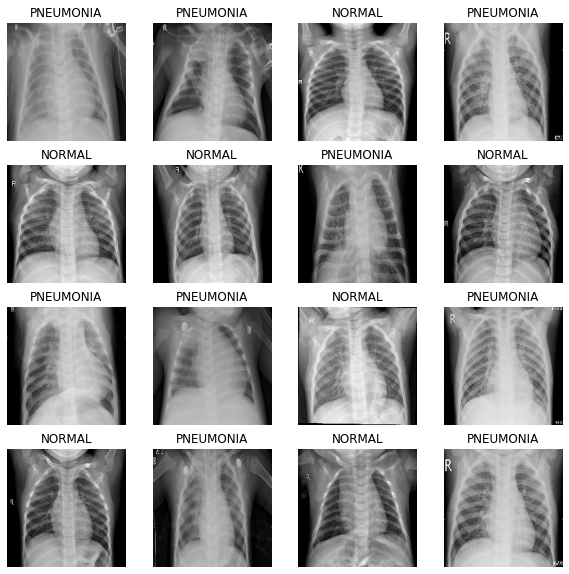

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## cnn 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
# 데이터 불균형 처리
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [20]:
# 모델훈련
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 62s 190ms/step - loss: 0.4149 - accuracy: 0.7900 - precision: 0.9457 - recall: 0.7617 - val_loss: 0.6268 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 186ms/step - loss: 0.2410 - accuracy: 0.9064 - precision: 0.9728 - recall: 0.8991 - val_loss: 1.1884 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 186ms/step - loss: 0.2069 - accuracy: 0.9258 - precision: 0.9765 - recall: 0.9225 - val_loss: 0.1320 - val_accuracy: 0.9587 - val_precision: 0.9918 - val_recall: 0.9516
Epoch 4/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1689 - accuracy: 0.9370 - precision: 0.9820 - recall: 0.9324 - val_loss: 0.0820 - val_accuracy: 0.9731 - val_precision: 0.9792 - val_recall: 0.9843
Epoch 5/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1601 - accura

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 55s 185ms/step - loss: 0.0630 - accuracy: 0.9763 - precision: 0.9957 - recall: 0.9723 - val_loss: 0.0682 - val_accuracy: 0.9740 - val_precision: 0.9973 - val_recall: 0.9674
Epoch 2/25
261/261 [==============================] - 48s 185ms/step - loss: 0.0437 - accuracy: 0.9840 - precision: 0.9961 - recall: 0.9823 - val_loss: 0.0595 - val_accuracy: 0.9808 - val_precision: 0.9794 - val_recall: 0.9948
Epoch 3/25
261/261 [==============================] - 48s 184ms/step - loss: 0.0486 - accuracy: 0.9847 - precision: 0.9954 - recall: 0.9839 - val_loss: 0.0823 - val_accuracy: 0.9750 - val_precision: 0.9907 - val_recall: 0.9752
Epoch 4/25
261/261 [==============================] - 48s 186ms/step - loss: 0.0543 - accuracy: 0.9816 - precision: 0.9967 - recall: 0.9784 - val_loss: 0.0704 - val_accuracy: 0.9760 - val_precision: 0.9973 - val_recall: 0.9699
Epoch 5/25
261/261 [==============================] - 49s 189ms/step - loss: 0.0545 - accura

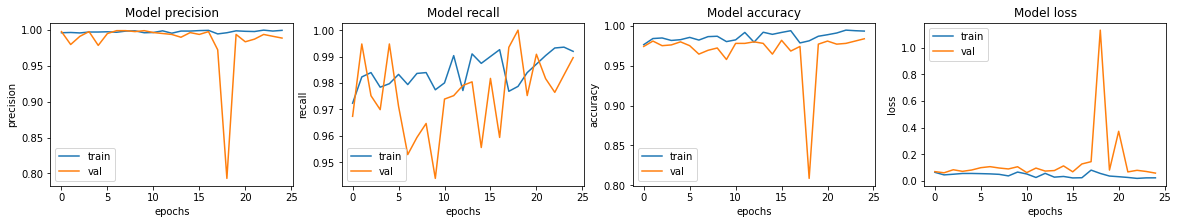

In [23]:
#결과확인
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [24]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.9479 - accuracy: 0.7388 - precision: 0.7067 - recall: 0.9949
Loss: 1.9478952884674072,
Accuracy: 0.7387820482254028,
Precision: 0.7067395448684692,
Recall: 0.9948717951774597


## 회고
- 프로젝트에서 어려웠던점  
몸살과 컨디션 저하로 슬럼프가 와서 프로젝트를 열심히 하지 못하였습니다 ㅜㅜ
- 프로젝트를 진행하면서 알아낸점 혹은 아직 모호한점  
폐렴같은 의료용데이터도 딥러닝을 사용하여 발전할 수 있구나 새로운 분야에 대해 배웠습니다.
- 루브릭 평가 지표를 맞추기 위해 시도한 것들  
이번 프로젝트를 할때 시간에 밀려서 잘 알아보지 못하였습니다.
- 만약에 루브릭 평가 관련 지표를 달성하지 못했을때 이유 추정  
이해도와 시간이 부족하였습니다.
- 자기다짐  
이번 폐렴노드는 10주차 방학때 다시 진행하고 공부를 다시해야겠습니다. 바쁜 프로그램 일정으로 체력적으로 정신적으로 힘들어서 1주일 동안 노드와 ex를 잘 진행하지 못하고 있습니다 ㅜㅜ 빨리 회복하여서 열심히 할것이고 앞으로 컨디션 관리를 잘해서 지치지 않도록 노력할 것입니다.